In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.1 MB/s 
     |████████████████████████████████| 1.8 MB 61.4 MB/s 
     |████████████████████████████████| 103 kB 67.1 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 10
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest', 'fold']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training fold']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    data.loc[val_ind, "fold"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development fold - fold {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation fold - fold {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training fold,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 4,37.32%,48.77%,6.38%,2.09%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['fold'].value_counts())

train_data = data[data['fold'].isin([i for i in range(CFG.num_split // 2)])]
test_data = data[~data['fold'].isin([i for i in range(CFG.num_split // 2)])]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
1.0    113887
0.0    113887
2.0    113882
3.0    113882
5.0    113881
4.0    113881
6.0    113881
8.0    113877
9.0    113877
7.0    113877
Name: fold, dtype: int64
Train data: 
Num of data: 569419
Num of unique id: 569419
Num of unique poi: 369990
Mean num of unique poi: 1.5390118651855456
Test data: 
Num of data: 569393
Num of unique id: 569393
Num of unique poi: 369982
Mean num of unique poi: 1.5389748690476834
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)]), col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)
test_data = recall_knn(data.loc[~data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/210 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Num of unique id: 569419
Num of train data: 13922913
Pos rate: 0.07232092881712325
                       id          match_id     kdist  kneighbors  \
5953610  E_749bb96c4912b4  E_846eb60bfefc37  0.015479        10.0   
6973496  E_3f166e4e718e7b  E_12f8b9e368f589  0.025110        12.0   
4676352  E_3653e257ef99ce  E_54b6e0930dcaf1  0.005464         8.0   
5054782  E_e06201ba184b87  E_39255f5674c5a5  0.070453         8.0   
5614933  E_dc3eca16cebfa6  E_dd04e3ec6df7df  0.001505         9.0   

        point_of_interest  fold  kdist_country  kneighbors_country  \
5953610  P_c03ebca8773103   4.0       0.015477                11.0   
6973496  P_b0525508200059   1.0       0.018715                13.0   
4676352  P_4a99ced6ac1c92   1.0       0.005437                 8.0   
5054782  P_688928ff6bb27f   0.0       0.063279                17.0   
5614933  P_dec1e2db7abc6d   1.0       0.001504                 9.0   

         kdist_diff  kneighbors_mean  label  
5953610    0.000133      

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226097362455303


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0501015
[100]	valid_0's binary_logloss: 0.0483931
[150]	valid_0's binary_logloss: 0.0475867
[200]	valid_0's binary_logloss: 0.0471331
[250]	valid_0's binary_logloss: 0.0468228
[300]	valid_0's binary_logloss: 0.0466042
[350]	valid_0's binary_logloss: 0.0463464
[400]	valid_0's binary_logloss: 0.0461989
[450]	valid_0's binary_logloss: 0.046109
[500]	valid_0's binary_logloss: 0.0459947
[550]	valid_0's binary_logloss: 0.0458807
[600]	valid_0's binary_logloss: 0.0457701
[650]	valid_0's binary_logloss: 0.0457126
[700]	valid_0's binary_logloss: 0.0455944
[750]	valid_0's binary_logloss: 0.0455158
[800]	valid_0's binary_logloss: 0.0454438
[850]	valid_0's binary_logloss: 0.0453747
[900]	valid_0's binary_logloss: 0.0453101
[950]	valid_0's binary_logloss: 0.0452604
[1000]	valid_0's binary_logloss: 0.0452
[1050]	valid_0's binary_logloss: 0.0451251
[1100]	valid_0's binary_logloss: 0.0450729
[1150]	valid_0's binary_logloss: 0.045016
[1200]	valid_0's binary_logloss: 0.0

In [ ]:
del train_data
gc.collect()

87

#Check Feature Importances

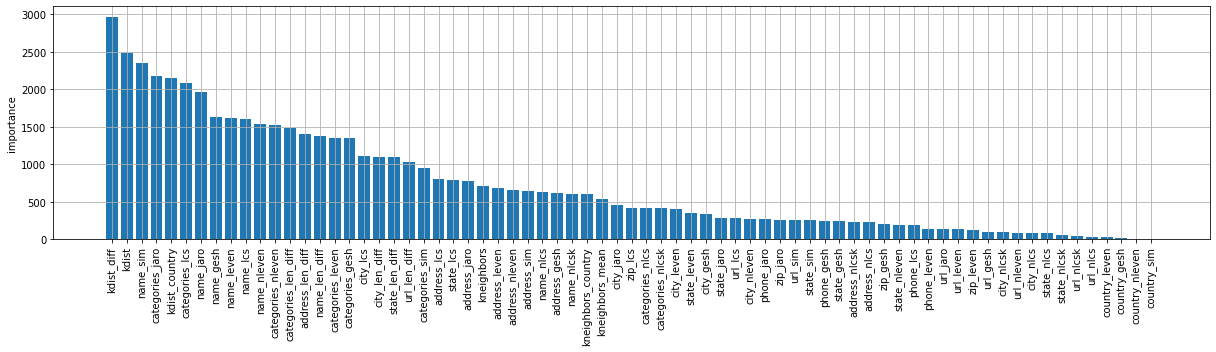

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 210 kB 48.0 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 112 kB 48.7 MB/s 
     |████████████████████████████████| 146 kB 47.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=8025433edba519ccbc26b0d8bb891fa145dd008cc7ed79282e87a3f21c7b1c4f
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-24 22:46:51,790] A new study created in memory with name: no-name-72bb9d04-a0f2-48f9-8c3f-fcdc4ff77dc0
[I 2022-05-24 22:47:18,456] Trial 0 finished with value: 0.8266653406137184 and parameters: {'threshold': 0.6252782098279436}. Best is trial 0 with value: 0.8266653406137184.


CV: 0.826665


[I 2022-05-24 22:47:39,374] Trial 1 finished with value: 0.8101798829549355 and parameters: {'threshold': 0.2799065091634805}. Best is trial 0 with value: 0.8266653406137184.


CV: 0.810180


[I 2022-05-24 22:48:00,483] Trial 2 finished with value: 0.8272771302422023 and parameters: {'threshold': 0.5250815782104163}. Best is trial 2 with value: 0.8272771302422023.


CV: 0.827277


[I 2022-05-24 22:48:20,753] Trial 3 finished with value: 0.8266726646267829 and parameters: {'threshold': 0.490223304936346}. Best is trial 2 with value: 0.8272771302422023.


CV: 0.826673


[I 2022-05-24 22:48:41,880] Trial 4 finished with value: 0.8273159690365514 and parameters: {'threshold': 0.5300756539798495}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.827316


[I 2022-05-24 22:49:04,767] Trial 5 finished with value: 0.7036528094471779 and parameters: {'threshold': 0.047565121113741005}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.703653


[I 2022-05-24 22:49:26,457] Trial 6 finished with value: 0.8267575878072345 and parameters: {'threshold': 0.4938075532172356}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.826758


[I 2022-05-24 22:49:47,527] Trial 7 finished with value: 0.8255911711139473 and parameters: {'threshold': 0.4605426088434488}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.825591


[I 2022-05-24 22:50:06,933] Trial 8 finished with value: 0.7387730548899781 and parameters: {'threshold': 0.9715932912730237}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.738773


[I 2022-05-24 22:50:27,510] Trial 9 finished with value: 0.8186531367479095 and parameters: {'threshold': 0.7562685599267668}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.818653


[I 2022-05-24 22:50:48,520] Trial 10 finished with value: 0.79504559361184 and parameters: {'threshold': 0.20022640289690258}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.795046


[I 2022-05-24 22:51:08,785] Trial 11 finished with value: 0.821600609155339 and parameters: {'threshold': 0.7245343238205466}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.821601


[I 2022-05-24 22:51:29,062] Trial 12 finished with value: 0.8158262634052855 and parameters: {'threshold': 0.32334129542121914}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.815826


[I 2022-05-24 22:51:49,481] Trial 13 finished with value: 0.8264841582801561 and parameters: {'threshold': 0.6362023312558016}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.826484


[I 2022-05-24 22:52:09,264] Trial 14 finished with value: 0.7926318865395577 and parameters: {'threshold': 0.8884879290173185}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.792632


[I 2022-05-24 22:52:29,639] Trial 15 finished with value: 0.8177083556794895 and parameters: {'threshold': 0.34203515488753167}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.817708


[I 2022-05-24 22:52:50,211] Trial 16 finished with value: 0.8272800859920759 and parameters: {'threshold': 0.6010003773540968}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.827280


[I 2022-05-24 22:53:10,471] Trial 17 finished with value: 0.8145253300520001 and parameters: {'threshold': 0.7898927328412483}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.814525


[I 2022-05-24 22:53:30,526] Trial 18 finished with value: 0.8265780049408267 and parameters: {'threshold': 0.6290273483967457}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.826578


[I 2022-05-24 22:53:51,766] Trial 19 finished with value: 0.821584292902843 and parameters: {'threshold': 0.3867422689271082}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.821584


[I 2022-05-24 22:54:12,493] Trial 20 finished with value: 0.7939731434008963 and parameters: {'threshold': 0.19595608815422083}. Best is trial 4 with value: 0.8273159690365514.


CV: 0.793973


[I 2022-05-24 22:54:33,104] Trial 21 finished with value: 0.8275871788962823 and parameters: {'threshold': 0.5799512943289228}. Best is trial 21 with value: 0.8275871788962823.


CV: 0.827587


[I 2022-05-24 22:54:53,903] Trial 22 finished with value: 0.8275036378401237 and parameters: {'threshold': 0.5865142997570216}. Best is trial 21 with value: 0.8275871788962823.


CV: 0.827504


[I 2022-05-24 22:55:13,934] Trial 23 finished with value: 0.8275768597434022 and parameters: {'threshold': 0.5510239285489734}. Best is trial 21 with value: 0.8275871788962823.


CV: 0.827577


[I 2022-05-24 22:55:34,414] Trial 24 finished with value: 0.8217974340544824 and parameters: {'threshold': 0.7222357690390834}. Best is trial 21 with value: 0.8275871788962823.


CV: 0.821797


[I 2022-05-24 22:55:55,639] Trial 25 finished with value: 0.8243468592232112 and parameters: {'threshold': 0.43246513799215575}. Best is trial 21 with value: 0.8275871788962823.


CV: 0.824347


[I 2022-05-24 22:56:15,264] Trial 26 finished with value: 0.808358717445131 and parameters: {'threshold': 0.8273775283901659}. Best is trial 21 with value: 0.8275871788962823.


CV: 0.808359


[I 2022-05-24 22:56:36,107] Trial 27 finished with value: 0.8276197501669437 and parameters: {'threshold': 0.5772944141182678}. Best is trial 27 with value: 0.8276197501669437.


CV: 0.827620


[I 2022-05-24 22:56:56,773] Trial 28 finished with value: 0.824959236352571 and parameters: {'threshold': 0.6719198312997164}. Best is trial 27 with value: 0.8276197501669437.


CV: 0.824959


[I 2022-05-24 22:57:17,938] Trial 29 finished with value: 0.827617695067478 and parameters: {'threshold': 0.5664068900100514}. Best is trial 27 with value: 0.8276197501669437.


CV: 0.827618


[I 2022-05-24 22:57:39,718] Trial 30 finished with value: 0.8241026296366665 and parameters: {'threshold': 0.6859783047818948}. Best is trial 27 with value: 0.8276197501669437.


CV: 0.824103


[I 2022-05-24 22:57:59,575] Trial 31 finished with value: 0.82761600264409 and parameters: {'threshold': 0.5666957743832488}. Best is trial 27 with value: 0.8276197501669437.


CV: 0.827616


[I 2022-05-24 22:58:20,593] Trial 32 finished with value: 0.8232816604274904 and parameters: {'threshold': 0.4123745227516308}. Best is trial 27 with value: 0.8276197501669437.


CV: 0.823282


[I 2022-05-24 22:58:41,462] Trial 33 finished with value: 0.8276717437859055 and parameters: {'threshold': 0.5597520404595735}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827672


[I 2022-05-24 22:59:01,499] Trial 34 finished with value: 0.8269887786898084 and parameters: {'threshold': 0.5033163528309293}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826989


[I 2022-05-24 22:59:21,997] Trial 35 finished with value: 0.825466159325496 and parameters: {'threshold': 0.6595263862411344}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.825466


[I 2022-05-24 22:59:42,220] Trial 36 finished with value: 0.8272760022150206 and parameters: {'threshold': 0.5204825071556418}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827276


[I 2022-05-24 23:00:03,123] Trial 37 finished with value: 0.8276235104096783 and parameters: {'threshold': 0.5604641645664742}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827624


[I 2022-05-24 23:00:24,688] Trial 38 finished with value: 0.8255941194876018 and parameters: {'threshold': 0.46004312070042963}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.825594


[I 2022-05-24 23:00:45,865] Trial 39 finished with value: 0.8018141845218679 and parameters: {'threshold': 0.23062683511234322}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.801814


[I 2022-05-24 23:01:09,280] Trial 40 finished with value: 0.7037988553750876 and parameters: {'threshold': 0.04765027836226143}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.703799


[I 2022-05-24 23:01:31,156] Trial 41 finished with value: 0.82764349381307 and parameters: {'threshold': 0.5726789596227884}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827643


[I 2022-05-24 23:01:51,210] Trial 42 finished with value: 0.8275308240641625 and parameters: {'threshold': 0.5456954053533801}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827531


[I 2022-05-24 23:02:12,212] Trial 43 finished with value: 0.8263910047184159 and parameters: {'threshold': 0.4804201912371789}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826391


[I 2022-05-24 23:02:33,352] Trial 44 finished with value: 0.8270918352225765 and parameters: {'threshold': 0.6095185556355188}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827092


[I 2022-05-24 23:02:53,360] Trial 45 finished with value: 0.8221064599366852 and parameters: {'threshold': 0.7181845664610436}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.822106


[I 2022-05-24 23:03:14,899] Trial 46 finished with value: 0.8202127353912294 and parameters: {'threshold': 0.3690821323146883}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.820213


[I 2022-05-24 23:03:36,256] Trial 47 finished with value: 0.8245568585687917 and parameters: {'threshold': 0.4366730817685667}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.824557


[I 2022-05-24 23:03:57,426] Trial 48 finished with value: 0.8272364238718946 and parameters: {'threshold': 0.5193101537651692}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827236


[I 2022-05-24 23:04:17,254] Trial 49 finished with value: 0.8132667940140681 and parameters: {'threshold': 0.7990320416684252}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.813267


[I 2022-05-24 23:04:38,269] Trial 50 finished with value: 0.8262842359801463 and parameters: {'threshold': 0.6410314750357426}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826284


[I 2022-05-24 23:04:59,620] Trial 51 finished with value: 0.8276529257370471 and parameters: {'threshold': 0.570939509448123}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827653


[I 2022-05-24 23:05:20,690] Trial 52 finished with value: 0.8271517283627962 and parameters: {'threshold': 0.6073654555622506}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827152


[I 2022-05-24 23:05:42,552] Trial 53 finished with value: 0.8267769148464557 and parameters: {'threshold': 0.49414100420679846}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826777


[I 2022-05-24 23:06:02,530] Trial 54 finished with value: 0.8275984942082191 and parameters: {'threshold': 0.553956089699925}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827598


[I 2022-05-24 23:06:23,653] Trial 55 finished with value: 0.8259169376602675 and parameters: {'threshold': 0.4683086379468513}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.825917


[I 2022-05-24 23:06:43,428] Trial 56 finished with value: 0.8229153125019024 and parameters: {'threshold': 0.7057105843083522}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.822915


[I 2022-05-24 23:07:04,177] Trial 57 finished with value: 0.8266965249248533 and parameters: {'threshold': 0.6226703807792946}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826697


[I 2022-05-24 23:07:24,791] Trial 58 finished with value: 0.8192828855744418 and parameters: {'threshold': 0.7506116962282676}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.819283


[I 2022-05-24 23:07:44,714] Trial 59 finished with value: 0.8276381449149535 and parameters: {'threshold': 0.5689468067561857}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827638


[I 2022-05-24 23:08:05,352] Trial 60 finished with value: 0.8253648728974086 and parameters: {'threshold': 0.662165281821615}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.825365


[I 2022-05-24 23:08:26,155] Trial 61 finished with value: 0.8275944626368863 and parameters: {'threshold': 0.5796386793437209}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827594


[I 2022-05-24 23:08:46,187] Trial 62 finished with value: 0.8274580511195834 and parameters: {'threshold': 0.5348071345818177}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827458


[I 2022-05-24 23:09:06,948] Trial 63 finished with value: 0.8276571657931685 and parameters: {'threshold': 0.5732519413972325}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827657


[I 2022-05-24 23:09:27,042] Trial 64 finished with value: 0.8272797056347215 and parameters: {'threshold': 0.5994994692281318}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827280


[I 2022-05-24 23:09:48,031] Trial 65 finished with value: 0.8271139776399581 and parameters: {'threshold': 0.5121556183587501}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827114


[I 2022-05-24 23:10:08,781] Trial 66 finished with value: 0.8264188674401332 and parameters: {'threshold': 0.6385973421829402}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826419


[I 2022-05-24 23:10:27,296] Trial 67 finished with value: 0.72553903474442 and parameters: {'threshold': 0.9805976499158957}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.725539


[I 2022-05-24 23:10:48,050] Trial 68 finished with value: 0.8256424872469019 and parameters: {'threshold': 0.46132528157458824}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.825642


[I 2022-05-24 23:11:07,849] Trial 69 finished with value: 0.8245632994530949 and parameters: {'threshold': 0.6785781258599761}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.824563


[I 2022-05-24 23:11:29,204] Trial 70 finished with value: 0.8238893516432091 and parameters: {'threshold': 0.42385163355512556}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.823889


[I 2022-05-24 23:11:50,065] Trial 71 finished with value: 0.8276526899468103 and parameters: {'threshold': 0.5759667511735578}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827653


[I 2022-05-24 23:12:09,974] Trial 72 finished with value: 0.8275173037279602 and parameters: {'threshold': 0.5859360782609027}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827517


[I 2022-05-24 23:12:30,792] Trial 73 finished with value: 0.8274970715904455 and parameters: {'threshold': 0.542197828114104}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827497


[I 2022-05-24 23:12:51,690] Trial 74 finished with value: 0.8276132724952313 and parameters: {'threshold': 0.5628332693178885}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827613


[I 2022-05-24 23:13:11,949] Trial 75 finished with value: 0.8268369977129162 and parameters: {'threshold': 0.49648596769647846}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826837


[I 2022-05-24 23:13:32,592] Trial 76 finished with value: 0.8265214591155453 and parameters: {'threshold': 0.6344296712826886}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826521


[I 2022-05-24 23:13:53,330] Trial 77 finished with value: 0.8236012870308503 and parameters: {'threshold': 0.6941059463472589}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.823601


[I 2022-05-24 23:14:14,243] Trial 78 finished with value: 0.8273665931199261 and parameters: {'threshold': 0.5927259770472258}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827367


[I 2022-05-24 23:14:34,751] Trial 79 finished with value: 0.8219816806712765 and parameters: {'threshold': 0.39183357038042893}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.821982


[I 2022-05-24 23:14:55,528] Trial 80 finished with value: 0.8272716330291646 and parameters: {'threshold': 0.5217591298751205}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827272


[I 2022-05-24 23:15:16,246] Trial 81 finished with value: 0.8276592561829947 and parameters: {'threshold': 0.5583688414030659}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827659


[I 2022-05-24 23:15:37,160] Trial 82 finished with value: 0.8276514646372374 and parameters: {'threshold': 0.5683858881014842}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827651


[I 2022-05-24 23:15:56,927] Trial 83 finished with value: 0.8275415630170274 and parameters: {'threshold': 0.547072193579037}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827542


[I 2022-05-24 23:16:17,285] Trial 84 finished with value: 0.8260907455256159 and parameters: {'threshold': 0.6461267347253565}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826091


[I 2022-05-24 23:16:37,787] Trial 85 finished with value: 0.8268609961187011 and parameters: {'threshold': 0.6173799020481736}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826861


[I 2022-05-24 23:16:57,851] Trial 86 finished with value: 0.8250784512154273 and parameters: {'threshold': 0.44813035103739873}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.825078


[I 2022-05-24 23:17:18,590] Trial 87 finished with value: 0.8266490244385776 and parameters: {'threshold': 0.4895160612421221}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826649


[I 2022-05-24 23:17:39,896] Trial 88 finished with value: 0.8276423371593934 and parameters: {'threshold': 0.5673624416524198}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827642


[I 2022-05-24 23:18:00,554] Trial 89 finished with value: 0.8273144762187611 and parameters: {'threshold': 0.5300416736644693}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827314


[I 2022-05-24 23:18:20,682] Trial 90 finished with value: 0.8197529948094838 and parameters: {'threshold': 0.7454672933292462}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.819753


[I 2022-05-24 23:18:40,574] Trial 91 finished with value: 0.8276057868015411 and parameters: {'threshold': 0.5630156015469937}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827606


[I 2022-05-24 23:19:01,302] Trial 92 finished with value: 0.8272826531255867 and parameters: {'threshold': 0.6006849351951417}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827283


[I 2022-05-24 23:19:22,173] Trial 93 finished with value: 0.8276658001102821 and parameters: {'threshold': 0.5747242273883099}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827666


[I 2022-05-24 23:19:42,073] Trial 94 finished with value: 0.8268682123986517 and parameters: {'threshold': 0.6172935154992439}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826868


[I 2022-05-24 23:20:02,860] Trial 95 finished with value: 0.8256047329907333 and parameters: {'threshold': 0.6576264915874774}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.825605


[I 2022-05-24 23:20:22,953] Trial 96 finished with value: 0.827620351293349 and parameters: {'threshold': 0.5774375157171274}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827620


[I 2022-05-24 23:20:44,149] Trial 97 finished with value: 0.8271091471846356 and parameters: {'threshold': 0.509993227781913}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827109


[I 2022-05-24 23:21:05,531] Trial 98 finished with value: 0.8261687065776151 and parameters: {'threshold': 0.4739214820473878}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.826169


[I 2022-05-24 23:21:25,856] Trial 99 finished with value: 0.8273307410201493 and parameters: {'threshold': 0.5319587585686564}. Best is trial 33 with value: 0.8276717437859055.


CV: 0.827331


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5597520404595735

In [ ]:
study.best_value

0.8276717437859055

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.827672


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,143712.000000,143712.000000,139705.000000,139705.000000,139705.000000,134742.000000,147693.000000,147693.0,147693.000000,147693.000000,...,147693.000000,147689.000000,147689.000000,147689.000000,147689.000000,147693.000000,147689.000000,147689.000000,147689.000000,1.476930e+05
mean,0.005671,6.243362,6.952027,0.003410,6.256290,0.415172,6.526870,1.0,0.262164,0.410103,...,0.999188,0.999269,0.001496,0.999255,1.998537,0.000027,0.000748,0.999269,0.999269,2.121845e-01
std,0.035463,5.247435,1.425688,0.018659,5.247693,2.358005,5.311724,0.0,0.312108,0.252406,...,0.028493,0.026780,0.054500,0.027198,0.053561,0.005204,0.027250,0.026780,0.026780,1.758968e-01
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.008405e-09
25%,0.000449,2.000000,6.000000,0.000340,2.000000,0.006067,2.000000,1.0,0.000000,0.203390,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,4.637454e-02
50%,0.001142,4.000000,7.000000,0.000883,4.000000,0.055047,5.000000,1.0,0.000000,0.388889,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.746361e-01
75%,0.003104,10.000000,8.000000,0.002445,10.000000,0.311997,10.000000,1.0,0.513838,0.590909,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.631103e-01
max,1.849236,19.000000,9.000000,1.396027,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.597520e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
8897860,E_a03f3a2ef87544,E_b809bd6e72e744,1.313560e-03,15.0,P_c1aa352e17bd2c,5.0,1.268504e-03,17.0,0.035519,16.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.189201
4064219,E_232afb81664a03,E_2fb18564e5b9f2,3.562391e-04,7.0,P_d733375b3a5e45,8.0,3.287190e-04,10.0,0.083719,8.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.282518
4863179,E_8a61dfa2ce6708,E_637b62697e015f,5.224336e-04,8.0,P_515834a6b73e6e,8.0,5.162491e-04,8.0,0.011980,8.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.004511
4128012,E_3fd95abdef5079,E_f018037552e19c,1.387444e-03,7.0,P_d33cd38b2ba5ce,8.0,1.322991e-03,7.0,0.048718,7.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.007778
1654775,E_e7dad894270ef6,E_5f6f0ef07696f2,2.368302e-04,2.0,P_b1f69f3ff3d9db,8.0,2.313971e-04,2.0,0.023479,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.313457
2927672,E_242e9cf27b0cab,E_98b4f993f14bae,2.187890e-03,5.0,P_7b5a845adcc5f6,9.0,1.602650e-03,4.0,0.365170,4.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.384026
1758739,E_16af7f8325a9e1,E_c90a0e36f16deb,1.498267e-03,3.0,P_a25f3e3090d0e3,7.0,1.365001e-03,5.0,0.097631,4.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.338028
1764839,E_196b01236d9d44,E_0ef3b12cf573fa,1.605712e-04,3.0,P_e32728e4086937,7.0,6.480020e-05,2.0,1.477943,2.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.472841
11585753,E_2611ad006fd793,E_a7dc5279217e03,NaN,NaN,P_0b110b6ad50b5a,6.0,2.452784e-02,19.0,NaN,19.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.384631
1536976,E_b2b7292f042df6,E_a04f5e6b50b89c,2.077705e-03,2.0,P_b0cce65abee026,9.0,1.416100e-03,1.0,0.467202,1.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.238443


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
156208,E_22fefc408c1453,Кокс у Крамма,55.685171,37.574768,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auditoriums,P_d07b22b3d198cd,4,7.0
840834,E_bcd260b40a2beb,выжить любой ценой,55.685427,37.573136,NaN,NaN,NaN,NaN,RU,NaN,NaN,Schools,P_d07b22b3d198cd,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
134544,E_1e28859d586f1c,Diamonad Resturants,24.698921,46.691799,NaN,Riyadh,Riyadh,12222,SA,NaN,NaN,Chinese Restaurants,P_7bd5004473bd89,1,6.0
939803,E_d31672240ea2f8,Diamond | دايموند,24.699541,46.692298,Localizer Mall,Riyadh,Riyadh Province,12222,SA,NaN,NaN,Asian Restaurants,P_7bd5004473bd89,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
566933,E_7f6c26b59fecb8,Возле кабинета физики,55.684481,37.848049,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_39825af8c0c623,4,5.0
754036,E_a95fa61ab00d62,Лицей № 1793 «Жулебино» (1),55.683918,37.847857,"Жулебинский бул., 38",Москва,Москва,109431,RU,http://lyc1793uv.mskobr.ru,4957040031,Schools,P_39825af8c0c623,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
144920,E_207c7c2ec5bff5,Царство 702,55.690095,37.595215,NaN,NaN,NaN,NaN,RU,NaN,NaN,Campgrounds,P_515834a6b73e6e,4,8.0
277524,E_3e4c05bed645ff,Кинодас,55.689700,37.595649,Шверника 19/2,NaN,NaN,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_515834a6b73e6e,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
212361,E_2fad2f1cefa8cb,Boğaziçi Köprüsü,41.044655,29.034513,Türkiye,NaN,NaN,NaN,TR,NaN,NaN,Bridges,P_fbe61733fcdebe,4,8.0
482919,E_6c887e5b1f3bd1,Bosphorus Bridge,41.044794,29.034750,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bridges,P_fbe61733fcdebe,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
633376,E_8e67a6fc249498,"Avillion Admiral Cove, PD",2.477697,101.846922,NaN,NaN,NaN,NaN,MY,NaN,NaN,Harbors / Marinas,P_df5184b3543580,4,7.0
913761,E_cd45acf71fec6d,Avillion Admiral Cove,2.477217,101.846254,NaN,NaN,NaN,NaN,MY,NaN,NaN,Hotels,P_df5184b3543580,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
217407,E_30d23c53ee8d6d,Antralina Hot Spring and Resort Spa,-7.178729,107.872297,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_965657077b7b93,4,7.0
1000044,E_e0a43b7f6ccb92,Antralina cipanas garut,-7.181188,107.888589,Cipanas garut,Garut,NaN,NaN,ID,NaN,NaN,Pools,P_965657077b7b93,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
728944,E_a3bd940d2898ec,I♡CR (360Mall),29.266775,47.993053,NaN,NaN,NaN,NaN,KW,NaN,NaN,Cafés,P_88a314f87fce38,4,6.0
747929,E_a8075b5d3cb89a,كوفي ريبابليك,29.267539,47.993469,360 Mall,NaN,NaN,NaN,KW,NaN,NaN,Cafés,P_88a314f87fce38,4,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
307114,E_44f98f587f06fb,кривое зеркало с Ильметовой,56.142524,47.173530,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_5271fd5f8c141e,4,9.0
1052274,E_ec6f30d64346b2,Сергей Тимашевский,56.142289,47.173142,NaN,NaN,NaN,NaN,RU,NaN,NaN,Radio Stations,P_5271fd5f8c141e,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
910322,E_cc80f09f70dcd5,"Swimming Pool Side Tower D,Mediterania Marina",-6.129719,106.828885,"Apartemen Mediterania Marina,Jalan Lodan Raya ...",Jakarta Utara,NaN,NaN,ID,NaN,NaN,Pools,P_f9ffa740dbdebe,4,8.0
915854,E_cdbb1834484b64,1505's Aston Hotel,-6.130637,106.831023,NaN,NaN,NaN,NaN,ID,NaN,NaN,Buildings,P_f9ffa740dbdebe,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
316523,E_47216afa56c4a1,Uzun Göl,40.620173,40.291644,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Great Outdoors,P_c1076f7b9f955d,4,7.0
1043287,E_ea686a43643f01,Uzungöl,40.615863,40.309669,NaN,NaN,NaN,NaN,TR,NaN,NaN,Lakes,P_c1076f7b9f955d,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
176017,E_2779328db31b5c,RCTI - PMC (Production Marketing Communication),-6.192467,106.766283,Kompleks RCTI Gd. Annex lantai 2,Jakarta Capital Region,Jakarta Capital Region,11530,ID,NaN,NaN,Coworking Spaces,P_7c5f67c96b0d53,4,5.0
445316,E_64153083f79f78,Loby got std 4 RCTI,-6.192109,106.765954,RCTI,Kebon jeruk,Jakarta barat,NaN,ID,NaN,NaN,"Parks, Music Venues",P_7c5f67c96b0d53,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
657313,E_93b665888c5454,Салон Красоты Stella,59.925553,30.347309,"Свечной пер., 5",Санкт-Петербург,NaN,NaN,RU,NaN,NaN,Salons / Barbershops,P_de9bbc1f0dedf6,1,7.0
694833,E_9c124a67523587,Стелла,59.925684,30.346976,"Свечной пер., 3",Санкт-Петербург,Санкт-Петербург,NaN,RU,NaN,NaN,"Salons / Barbershops, Cosmetics Shops",P_de9bbc1f0dedf6,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
508403,E_724bd1cf113c5f,#2D1B -Our Room 601,38.802273,30.540087,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_dc3926ef24d60e,4,7.0
834075,E_bb4f15d5c23d9b,çigiltepe kız yurdu kyk,38.802669,30.539983,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Residence Halls,P_dc3926ef24d60e,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
923017,E_cf577e544c2a17,KFC Malioboro,-7.792102,110.365781,Jalan Malioboro Yogyakarta,NaN,NaN,NaN,ID,NaN,NaN,Fast Food Restaurants,P_a1f14f636d67eb,4,8.0
936337,E_d254472926efd1,Kfc,-7.792138,110.366003,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_a1f14f636d67eb,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
103861,E_174802c5f09f5e,AŞTİ (Ankara Şehirlerarası Terminal İşletmecil...,39.917991,32.812353,Ankara/Türkiye,NaN,NaN,NaN,TR,NaN,NaN,Bus Stations,P_0c47b60beca9b9,4,5.0
540504,E_79760ff3698045,Efe Tur Ankara-Kocaeli Otobüsü,39.917895,32.812948,Istanbul Yolu,NaN,NaN,NaN,TR,NaN,NaN,Border Crossings,P_0c47b60beca9b9,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
374548,E_542696f376297a,Слизень С Зоологической,55.763694,37.578203,NaN,NaN,NaN,NaN,RU,NaN,NaN,Zoos,P_362b42ac17f411,4,8.0
384978,E_567d720088af4d,Упоротый зоопарк,55.765090,37.574320,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_362b42ac17f411,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
587563,E_840f8ee5e3a980,Кабинет Английского,51.520536,45.996495,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_c06463852144cd,4,5.0
673542,E_974d6f50d56d69,Школа № 95,51.521108,46.000443,"2-ая Садовая ул., 23",Саратов,Саратовская обл.,410004,RU,http://www.sarschool95.ru,8452203780,"Schools, Middle Schools",P_c06463852144cd,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
466401,E_68cb4b3864ab84,Str.Eat,35.899002,14.512811,Strait Street,Valletta,Valletta,VLT1433,MT,NaN,+35677787328,"Whisky Bars, Bistros, Burger Joints",P_e98879430788f2,2,8.0
981503,E_dc7d823d5baedb,Streat Whisky Bar & Bistro,35.898762,14.516374,NaN,Валлетта,Валлетта,NaN,MT,NaN,NaN,Bars,P_e98879430788f2,2,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
520512,E_74fb4d4f587b47,Empek-Empek ULU BINDAR,-7.783346,110.401830,"Jl.Laksda Adisucipto, km.6",Depok,Yogyakarta,NaN,ID,NaN,2743015015,Fast Food Restaurants,P_12304802835766,3,9.0
735376,E_a5329fcd2b119e,"""Pempek \""Ulu Bundar\""""",-7.783366,110.401657,Jalan Laksda Adisucipto,Sleman,DI Yogyakarta,NaN,ID,NaN,2743015015,"Indonesian Restaurants, Snack Places",P_12304802835766,3,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
30012,E_06b841f5861063,KXTv Karaoke,1.471716,124.831553,Manado Town Square,Manado,Sulawesi Utara,95114,ID,NaN,NaN,"Karaoke Bars, Music Venues, Buildings",P_f0bd876f7b65b0,4,5.0
856888,E_c0728736d78067,KXTV Manado Town Square,1.471890,124.831460,NaN,NaN,NaN,NaN,ID,NaN,NaN,Music Venues,P_f0bd876f7b65b0,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
65729,E_0eb6fec6298d03,LTA girlz Restroom Woodlands Checkpoint,1.445362,103.769087,NaN,NaN,NaN,NaN,SG,NaN,NaN,Border Crossings,P_ccd9b032e9f192,4,5.0
258180,E_39f7463049045b,Woodlands Checkpoint Berth Num 170,1.446649,103.768420,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_ccd9b032e9f192,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
36486,E_082fa321c1b5a7,"3/F Parking Level, The Globe Tower",14.553500,121.050410,32nd Street,Taguig City,NaN,NaN,PH,NaN,NaN,Parking,P_6ffcd0d7911f38,4,9.0
978783,E_dbe03275332df8,Globe Digital Media,14.553705,121.050069,"32nd St Cor 7th Ave, Bonifacio Global City, Ta...",Taguig City,National Capital Region,NaN,PH,NaN,NaN,Offices,P_6ffcd0d7911f38,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
679000,E_9885a52d071527,7-Eleven (เซเว่น อีเลฟเว่น),13.777965,100.506085,Samsen 13,Dusit,Bangkok,10300,TH,http://www.7eleven.co.th,NaN,Convenience Stores,P_dd146642118059,2,6.0
902136,E_caa178e6ac4d85,"7-11,Branch 2214, samsen 13",13.778010,100.505931,NaN,Wachira Phayaban,Bangkok,NaN,TH,NaN,NaN,NaN,P_dd146642118059,2,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
131889,E_1d90b73b3df37c,Verizon Wireless Reliable Conference Room,43.065118,-77.641993,133 Calkins Rd,Rochester,NY,14623,US,NaN,NaN,Conference Rooms,P_b11067844ae772,4,6.0
947272,E_d4c61a89028c65,Verizon Wireless Sales Training Room 1,43.065880,-77.643280,133 Calkins Rd,Rochester,NY,14623,US,NaN,NaN,Conference Rooms,P_b11067844ae772,4,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
470305,E_69b2e3a980ca68,7/11#13899 อาคารยูไนเต็ด,13.726933,100.531748,NaN,กรุงเทพมหานคร,กรุงเทพมหานคร,10500,TH,NaN,NaN,Convenience Stores,P_8e2ecb5441c0eb,2,9.0
1116138,E_faebd9e48c42e9,7-Eleven,13.727184,100.531226,NaN,Bangkok,Bangkok,10500,TH,http://www.7eleven.co.th,NaN,Convenience Stores,P_8e2ecb5441c0eb,2,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
135355,E_1e56bfed1ebc74,ปตท. (PTT),14.634369,102.745613,Det Udom Rd,"Nang Rong, Changwat Buriram",Buriram,NaN,TH,NaN,NaN,Gas Stations,P_ce9b997c2599c5,1,8.0
1048304,E_eb8c440cd469f4,7-Eleven,14.634383,102.745641,PTT Nong Bode,NaN,NaN,NaN,TH,NaN,NaN,Convenience Stores,P_ce9b997c2599c5,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
215979,E_307cf53343c95b,Abrams Chicken-Ribs-BBQ,35.896720,-77.542184,609 W Wilson St,Tarboro,NC,27886,US,http://www.abramsweb.com,NaN,BBQ Joints,P_4a0456f3e21248,1,6.0
817528,E_b7976c360eb07e,Abrams Bar-B-Q and Seafood,35.896893,-77.542506,609 W Wilson St,Tarboro,NC,27886,US,http://abramsweb.com,+12528231778,Food,P_4a0456f3e21248,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
235947,E_34f7919396afa5,"Venetian, Bellini 2104",36.121436,-115.168660,NaN,Paradise,NV,NaN,US,NaN,NaN,Event Spaces,P_53c8d21c6885d4,4,7.0
712993,E_a026e4f79c82a4,The Venetian Hotel Las Vegas,36.121058,-115.168545,NaN,Paradise,NV,NaN,US,NaN,NaN,Casinos,P_53c8d21c6885d4,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
913328,E_cd2c08c8dcc376,First Choice,-27.491958,153.153252,NaN,Capalaba,Queensland,NaN,AU,NaN,NaN,Liquor Stores,P_3c7ce1588512ad,1,5.0
939611,E_d30aa4cfe7ee79,First Choice Nursing Agency,-27.523433,153.196600,2 Rickey Street,Capalaba,QLD,4157,AU,NaN,NaN,Recruiting Agencies,P_3c7ce1588512ad,1,5.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,56121.000000,56121.000000,54343.000000,54343.000000,54343.000000,52751.000000,57224.000000,57224.0,57224.000000,57224.000000,...,57224.000000,57222.000000,57222.000000,57222.000000,57222.000000,57224.0,57222.000000,57222.000000,57222.000000,57224.000000
mean,0.007674,4.670373,6.988149,0.003414,4.657178,0.415177,4.926237,0.0,0.573857,0.607094,...,0.998095,0.998156,0.003810,0.998095,1.996313,0.0,0.001905,0.998156,0.998156,0.752639
std,0.112085,4.881371,1.417180,0.017906,4.855854,1.674997,5.003885,0.0,0.354291,0.248338,...,0.043603,0.042541,0.087207,0.043604,0.085082,0.0,0.043604,0.042541,0.042541,0.125498
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.559758
25%,0.000318,1.000000,6.000000,0.000238,1.000000,0.006786,1.000000,0.0,0.320840,0.440678,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.641904
50%,0.000908,2.000000,7.000000,0.000699,2.000000,0.060342,2.500000,0.0,0.644056,0.620690,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.739784
75%,0.003044,7.000000,8.000000,0.002286,7.000000,0.316041,7.500000,0.0,0.876558,0.800000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.857529
max,15.331446,19.000000,9.000000,1.588083,19.000000,70.660379,19.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
1450638,E_8c1df14356bbfb,E_3d47c0663a0e43,0.000535,2.0,P_e70056e7f30b8a,9.0,0.000523,2.0,0.023268,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.671504
835175,E_777e4c4b56fef9,E_630e8a737e1819,0.000077,1.0,P_a3a463bd43c519,9.0,0.000024,1.0,2.156725,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.678274
7842928,E_c5f4af2ad2db0f,E_38fa41d410898d,0.001177,13.0,P_f217a8126fba32,6.0,0.000584,9.0,1.016875,11.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.610451
5536495,E_b8ef6e34df31a3,E_d9f4d621d8aa15,0.002066,9.0,P_039bec7b417abf,7.0,0.002025,9.0,0.020454,9.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.604306
1605475,E_d1a3ee8619145f,E_fcbb04951aeb3e,0.002632,2.0,P_7e2ae0c7d25b0b,8.0,0.002632,2.0,0.000048,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.603868
6241719,E_f648fa3855542a,E_e99fc1f17bdebe,0.004363,10.0,P_669e2b874ef91b,6.0,0.003676,9.0,0.186675,9.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.653794
10790013,E_f328971f58d079,E_d3af457f57b46d,0.000632,18.0,P_c0dbff23291eab,7.0,0.000488,18.0,0.295997,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.891192
644458,E_21acd193a374c7,E_13e14e66f4b47f,0.002724,1.0,P_986414620f03f6,6.0,0.002134,1.0,0.276330,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.598582
1228873,E_286f0d518053b7,E_fc5f5e46c5f436,0.000773,2.0,P_a64aea59108a28,9.0,0.000556,2.0,0.390216,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.940463
1335794,E_5880cf6ddc3ff6,E_f227d05be3bfa2,0.000885,2.0,P_73fc84c0b5f902,7.0,0.000641,2.0,0.379864,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.575837


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
46832,E_0a7820ffa7a569,59a Vara do Trabalho - TRT - Lavradio,-22.911357,-43.183454,NaN,Río de Janeiro,NaN,NaN,BR,NaN,NaN,"Buildings, Courthouses",P_3afcfa6d75921a,0,9.0
468467,E_6945b22cf222eb,47 Vara Do Trabalho,-22.911751,-43.183087,NaN,Río de Janeiro,NaN,NaN,BR,NaN,NaN,Courthouses,P_8b1946cdcab966,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
107504,E_18198e8ea476e1,Padaria e Lanchonete Claret,-22.414579,-47.569191,"R. Quatorze, 1754",Rio Claro,SP,13500-270,BR,NaN,551935248635,"Bakeries, Cafés",P_2552a061ab07e6,0,8.0
1125026,E_fce55f18035010,Padaria Claret,-22.407686,-47.572330,R. 14,NaN,NaN,NaN,BR,NaN,NaN,Bakeries,P_060b3ffa09006a,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
106008,E_17c195ddcb0ef3,Redbox,37.735920,-97.362921,2261 N Amidon Ave,Wichita,KS,67204,US,http://www.redbox.com,8667332693,Video Stores,P_77c8a3e632ea97,0,8.0
250538,E_383edbdf3fd6c7,Redbox,37.723229,-97.363070,2261 N Amidon Ave,Wichita,KS,67204,US,http://www.redbox.com,NaN,Video Stores,P_09245dc2c29268,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
511118,E_72e70116431acd,James Gore's Grave,40.019323,-83.020431,NaN,Columbus,OH,43202,US,NaN,NaN,Cemeteries,P_5ecc1f2624c3d7,0,9.0
699869,E_9d3019e1fed8e5,Albert Magruder grave,40.022274,-83.021622,NaN,Columbus,OH,43202,US,NaN,NaN,Cemeteries,P_b4896b0866e9ac,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
197871,E_2c671b54065140,Verve Coffee Roasters,35.322645,139.554283,雪の下1-10-18,鎌倉市,神奈川県,248-0005,JP,https://vervecoffee.jp,+81467848851,"Coffee Shops, Cafés",P_1cfb23f884083e,1,8.0
276439,E_3e0ddfa9f0e2ed,バニヤンツリー コーヒーハウス（BANYAN TREE COFFE HOUSE）,35.323082,139.554527,雪ノ下1-8-38,Kamakura,Kanagawa,NaN,JP,NaN,NaN,"Cafés, Coffee Shops",P_b33a7541406780,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
443697,E_63b8763e21420a,Lom Leštinka,49.841436,15.973467,NaN,Skuteč,Pardubický,NaN,CZ,http://www.lestinkalom.cz,+420606630535,"Dive Spots, Lakes",P_bbbf5ce30cb6b0,1,6.0
1029113,E_e73563daf11775,Lom Zvěřinov,49.843710,15.971518,Leštinka 60,Leštinka,Pardubický kraj,539 73,CZ,NaN,NaN,Reservoirs,P_57bd68feac7bba,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
887797,E_c76eef4391e9c9,Günaydınnnn💃💃,37.084920,37.327211,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Cajun / Creole Restaurants, Frozen Yogurt Shop...",P_2967b9558b9217,1,7.0
1110373,E_f994ad4ba717ed,Güünnaayyddıınnnnnn,37.084918,37.327685,NaN,NaN,NaN,NaN,TR,NaN,NaN,Water Parks,P_c0bfa7f947be13,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
541726,E_79b9c31ee0e8b9,İstanbul 11.Asliye Ticaret Mahkemesi Duruşma S...,41.069332,28.980890,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_f2df149bcb3843,4,5.0
957230,E_d709fa3b770336,İstanbul 23. İcra Ceza Mahkemesi,41.069559,28.980268,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_a0656098f22442,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
551094,E_7bde724b719b9b,Level 44 Tower 2 Petronas Twin Towers,3.157915,101.711861,NaN,NaN,NaN,NaN,MY,NaN,NaN,Offices,P_51bc9a9d7df933,4,8.0
656371,E_937f8e9f0019fd,"Level 78, Tower 1",3.157955,101.711881,PETRONAS Twin Towers,Kuala Lumpur,WP Kuala Lumpur,50088,MY,NaN,NaN,Offices,P_3210c8199bb192,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
636849,E_8f2d2b40b97bda,Isis Hotel & Spa - Osiris Restaurant,37.024928,27.391578,Isis Hotel & Spa,Bodrum,Turkey,NaN,TR,NaN,NaN,Italian Restaurants,P_d6d269932492e2,0,5.0
643704,E_90b41373e4c995,İsis Hotel Restaurant,37.024863,27.391446,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Turkish Restaurants, Italian Restaurants",P_17b5a450b9edee,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
265221,E_3b90881e463d81,Möbel Boss,51.159413,6.504830,NaN,NaN,NaN,NaN,DE,NaN,NaN,Furniture / Home Stores,P_8eff49894c9c32,0,6.0
1069045,E_f043d98b980542,SB Möbel Boss,51.159754,6.504661,Erftstraße 51,Mönchengladbach,Nordrhein-Westfalen,41238,DE,https://moebel-boss.de/moebelhaeuser/moencheng...,+492166987100,Furniture / Home Stores,P_c7f49799e24be6,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
862346,E_c1b25445a4f378,Boston-Portsmouth Air Show,43.077571,-70.816069,1-199 Aviation Ave.,Portsmouth,NH,03801,US,NaN,NaN,Airports,P_cd0b6c6cbf15e7,0,8.0
1078756,E_f26b102bd1e4d6,Boston Portsmouth Airshow,43.081337,-70.815424,NaN,NaN,NH,NaN,US,NaN,NaN,Airports,P_85a44f49dd7719,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
268160,E_3c3a2feeff3720,세종대학교 광개토관 컨벤션홀,37.550388,127.073774,NaN,NaN,NaN,NaN,KR,NaN,NaN,Convention Centers,P_90102aa4dca962,2,7.0
986714,E_ddabda038a4e18,세종대학교 광개토관 15층 스카이레스토랑 찬,37.550310,127.073600,군자동 98,광진구,서울특별시,NaN,KR,NaN,NaN,College Academic Buildings,P_ac9828d709c652,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
553193,E_7c57534ddbbc0b,Cinema 21 Grage Mall Cirebon,-6.714212,108.551833,NaN,NaN,NaN,NaN,ID,NaN,NaN,Shopping Malls,P_649654e3afd4c0,4,7.0
1126020,E_fd1d600b27495e,Parkiran Grage Mall Cirebon,-6.713769,108.550639,NaN,NaN,NaN,NaN,ID,NaN,NaN,Shopping Malls,P_51cd5451b4f124,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
232910,E_3446d4e6b8d0bf,Pantai Klayar,-8.202107,111.093518,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_1fbb9b4630d15b,4,6.0
749393,E_a85a7ff79adc3d,Pantai Buyutan,-8.218101,110.921328,Pacitan,Pacitan,NaN,NaN,ID,NaN,NaN,Beaches,P_defb02631d1890,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
202256,E_2d60aa4df69bb5,Pay Ferry (Malé to Hulhulé),4.177992,73.516092,NaN,NaN,NaN,NaN,MV,NaN,NaN,Boats or Ferries,P_ef0d398b5088f6,1,6.0
292216,E_419eb8f03e564e,Ferry No 06,4.178281,73.516524,Male' / Airport,NaN,NaN,NaN,MV,NaN,NaN,Boats or Ferries,P_b6b3691f03b9a1,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
159615,E_23c31411da2b86,DHL Global Forwarding (Thailand) Head Office,13.745103,100.562178,K Tower A,Vadhana,Bangkok,10110,TH,NaN,NaN,Offices,P_89c92452710e4f,1,7.0
952313,E_d5ecc9dee3d0cb,"Azbil (Thailand) Co., Ltd.",13.744891,100.561738,K Tower,Vadhana,NaN,NaN,TH,NaN,NaN,Offices,P_48fbe41b7f8942,3,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
378807,E_551b61293e6bb8,Tegal parang utara,-6.242560,106.832838,Jl. Tegal Parang Selatan,Jakarta Selatan,Jakarta Capital Region,12790,ID,NaN,NaN,Arcades,P_3dde07307ad4ba,0,5.0
797497,E_b31d43b1e87c6f,Indomaret tegal parang,-6.246472,106.832112,Jl.tegal parang,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_a0fffe8454ae61,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
209140,E_2eeecfaf3875a0,D Block - The Harwich and Dovercourt High School,51.92989,1.260316,NaN,Dovercourt,Essex,CO12 3TG,GB,NaN,01255245460,College Arts Buildings,P_0d41ae930ea88c,0,6.0
408641,E_5bd44fcf7355f0,Santander Dovercourt Harwich,51.94549,1.289360,NaN,NaN,NaN,NaN,GB,NaN,NaN,Buildings,P_e7e2029c329aa2,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
553075,E_7c501b60c44c2b,Burger King,37.266097,126.999682,팔달구 덕영대로 924 6층,수원시,경기도,16622,KR,http://www.burgerking.co.kr,031-240-1620,"Fast Food Restaurants, Burger Joints",P_ec087bac355df7,0,7.0
1014915,E_e403217d729b8f,Burger King,37.265924,126.999351,팔달구 덕영대로 924 3층,수원시,경기도,16622,KR,http://www.burgerking.co.kr,312401030,Fast Food Restaurants,P_ab616de889866f,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
211517,E_2f7c46a3c20cba,San Miguel,6.201901,-75.571674,NaN,Medellín,Antioquia,NaN,CO,NaN,NaN,Paella Restaurants,P_388647d5c945db,0,5.0
500668,E_70901417609d05,San Miguel,6.199325,-75.570511,NaN,NaN,NaN,NaN,CO,NaN,NaN,Residential Buildings (Apartments / Condos),P_1c488a3c065a53,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
22850,E_0522adadac34ba,Kajari Singaparna,-7.345051,108.108661,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ed6fb5ca9325c4,0,9.0
222467,E_31f52d5dc6045e,Bank Sinarmas Singaparna,-7.350074,108.119810,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_b14efc4d38a1b5,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
364432,E_51e4c73cc493aa,Uludag Universitesi Tekstil Labaratuvari,40.225450,28.877290,Uludag Universitesi,NaN,NaN,NaN,TR,NaN,NaN,College Labs,P_6152d3299bf70a,1,7.0
539503,E_793e2df52e9ba8,Uludag Uni,40.223843,28.873405,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Quads,P_b2a7c20b56c877,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
211905,E_2f92fc375daa01,McDonald's,45.307363,-66.020724,450 Westmorland Road,Saint John,NB,E2J 4Z2,CA,https://www.mcdonalds.com/ca/en-ca/restaurant-...,5066342703,Fast Food Restaurants,P_3463af1b594e29,0,5.0
285995,E_403531d3ce0ca1,McDonald's,45.404426,-65.971819,Old Hampton rd,Quispamsis,NB,NaN,CA,NaN,NaN,NaN,P_2d6cd19cd9fd23,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
299922,E_43580987eb20c9,동우대학 청초관,38.192075,128.551589,노학동 동우대학 청초관,속초시,강원도,NaN,KR,NaN,NaN,College Academic Buildings,P_2e6eca429808e1,0,8.0
662267,E_94cc894c669c77,동우대학 청사관,38.190651,128.554197,강원도 속초시 노학동 동우대학 청사관,NaN,NaN,NaN,KR,NaN,NaN,College Administrative Buildings,P_d4ca1e209ba7de,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
143672,E_2031f7aa934a30,IBM CIC F/G Cafeteria,49.225330,16.577775,Technická 21,Brno,South Moravian Region,616 00,CZ,http://www.eurest-brno.cz/ibm/menu,NaN,Corporate Cafeterias,P_f541858d58d786,0,9.0
929735,E_d0d9fce74bae71,IBM CIC Brno D/E Cafeteria,49.224955,16.578006,Technická,Brno,Jihomoravský,NaN,CZ,NaN,NaN,Corporate Cafeterias,P_c7165c7a000c75,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
689309,E_9acfea9d631498,Gedung A FKIP Universitas Mataram,-8.586086,116.091074,Universitas Mataram,NaN,NaN,NaN,ID,NaN,NaN,College Academic Buildings,P_0ca34fe3742e75,0,8.0
693983,E_9be0cba7e3158c,FKIP Unram,-8.585767,116.090745,Jalan Majapahit no 62,Mataram,Nusa Tenggara Barat,NaN,ID,NaN,NaN,"General Colleges & Universities, College Acade...",P_019ec6d59a7045,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
857140,E_c0806e567c11e5,Hoa liability insurance,30.226469,-81.379842,816 A1a N Ste 206,Ponte Vedra Beach,FL,32082,US,NaN,+19042857683,Business Services,P_f9f5cd77f27027,2,8.0
1049494,E_ebd335abe04f3c,What is excess liability,30.201296,-81.381837,816 A1a N #206,Ponte Vedra Beach,FL,32082,US,NaN,+19042857683,"Business Services, Industrial Estates",P_e810c72cc6f2aa,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
677685,E_983a77b60923e6,Rumah Sakit Pondok Indah,-6.283519,106.781691,Jalan Metro Duta Kav. UE,Jakarta Selatan,DKI Jakarta,12310,ID,http://www.rspondokindah.co.id,217657525,"Hospitals, Medical Centers, Emergency Rooms",P_8bb73623a1aed8,4,6.0
1083314,E_f37033e366c3d4,Laboratorium RS. Pondok Indah,-6.283484,106.781634,Jl. Metro Duta kav UE,Jakarta,Indonesia,NaN,ID,NaN,NaN,"Hospitals, Medical Labs",P_6ad7ec200131f5,2,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
339417,E_4c48937597ea1d,Dış Hatlar Terminali,37.242587,27.676688,Milas Bodrum Airport (BJV),Milas,Muğla,NaN,TR,http://www.milas-bodrumairport.com,NaN,Airport Terminals,P_bfd4397c9b79b7,3,7.0
567418,E_7f8728e7fd5578,İç Hatlar Terminali,37.243259,27.672945,Milas,NaN,NaN,NaN,TR,NaN,NaN,Airport Terminals,P_91451f8da4b4cc,1,9.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,855535.000000,855535.000000,847940.000000,847940.000000,847940.000000,270256.000000,857635.000000,857635.0,857635.000000,857635.000000,...,857635.000000,857627.000000,857627.000000,857627.000000,857627.000000,857635.0,857627.000000,857627.000000,857627.000000,857635.000000
mean,0.001469,1.028669,6.997301,0.000777,1.029096,0.428106,1.091628,1.0,0.818176,0.911823,...,0.999542,0.999611,0.000814,0.999593,1.999221,0.0,0.000407,0.999611,0.999611,0.963485
std,0.016027,2.659634,1.414285,0.005707,2.680113,1.868088,2.769043,0.0,0.348264,0.194882,...,0.021402,0.019493,0.040308,0.020146,0.038986,0.0,0.020154,0.019493,0.019493,0.086327
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.559758
25%,0.000000,0.000000,6.000000,0.000000,0.000000,0.007729,0.000000,1.0,0.834796,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.986277
50%,0.000000,0.000000,7.000000,0.000000,0.000000,0.068861,0.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999988
75%,0.000209,1.000000,8.000000,0.000150,1.000000,0.339161,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999995
max,4.246996,19.000000,9.000000,1.099809,19.000000,225.865403,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
135343,E_3cb836f6a55df1,E_3cb836f6a55df1,0.000000,0.0,P_296222c02a96ca,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999986
315909,E_8def769bf8dac3,E_8def769bf8dac3,0.000000,0.0,P_fe3436e37bc706,9.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999987
975430,E_b64868d8415276,E_98d8b9351476f2,0.000046,1.0,P_2524384bd170eb,6.0,0.000045,1.0,0.014787,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999603
12890165,E_79125aeba4c9b9,E_1f2959315c249f,NaN,NaN,P_eec1bb588e8313,9.0,0.000260,1.0,NaN,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999537
340831,E_990bc552252d5f,E_990bc552252d5f,0.000000,0.0,P_7e8fba2fd3a4a0,6.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999991
513215,E_e6a020577f5c06,E_e6a020577f5c06,0.000000,0.0,P_eae1e4aa99181c,6.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999998
851372,E_7ec7a822e15aa4,E_139762219803ab,0.000213,1.0,P_e55978ccc78e28,5.0,0.000200,1.0,0.066017,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.759902
730974,E_48a53283553b96,E_9e3bd671103ec4,0.001090,1.0,P_273fa1cbc9a286,5.0,0.000854,1.0,0.276605,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.961170
957205,E_ae0c42e4a40dc6,E_0784d2f6dd510e,0.000084,1.0,P_5644f0001f8336,5.0,0.000081,1.0,0.036481,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.890551
1573856,E_c36045ecd44d4b,E_d6af77c8001bfa,0.000145,2.0,P_9a5ee4984e991d,8.0,0.000145,2.0,0.000009,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.969690


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
17158,E_03e10ea3681baf,Hattena Hatay Sofrası,39.905934,32.821527,1. Cadde No:41/A Balgat,Ankara,NaN,NaN,TR,NaN,3122202043,"Turkish Restaurants, Steakhouses",P_29c291f2885803,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
449084,E_64eacb06d59d17,Bonita Flowers & Gifts,26.208854,-98.228878,610 N 10th St,McAllen,TX,78501,US,http://www.bonitaflowersandgifts.com?y_source=...,9566864830,Flower Shops,P_5729c6ea0d0135,1,9.0
1120108,E_fbd098df93ca61,Bonita Flowers And Gifts 1,26.209316,-98.229189,610 N 10th St #4,McAllen,TX,78501,US,NaN,9566864830,Flower Shops,P_5729c6ea0d0135,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
668478,E_962a1d5b4a4f61,โรบินสัน ชั้น 7,7.003472,100.468617,Robinson Hat Yai,Hat Yai,NaN,NaN,TH,NaN,NaN,"Food Courts, Shopping Malls",P_9dd1cdeea50e3f,2,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
72479,E_1036bae6f3c19f,Enes Kitap Sarayı,37.871573,32.494681,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bookstores,P_5bc24060c377de,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
956476,E_d6deab619bdadb,Моя Аптека,54.867775,83.087952,Учительская 8,Новосибирск,NaN,NaN,RU,NaN,NaN,Pharmacies,P_80fa672c961377,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
571895,E_808d9aac073e46,Fish & Co,6.035433,116.128468,"G-817, Ground Floor, 1Borneo Hypermall",Kota Kinabalu,Sabah,88400,MY,http://www.fish-co.com,88485878,"Seafood Restaurants, American Restaurants",P_a8c6a2b1e017f8,1,7.0
841144,E_bce662f841182c,Fish & Co. 1 Borneo Hypermall,6.035469,116.128368,NaN,NaN,Sabah,NaN,MY,NaN,NaN,Seafood Restaurants,P_a8c6a2b1e017f8,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1051357,E_ec3b653da3f0bb,上外宾馆,31.282943,121.479574,赤峰路555号,上海,中国,NaN,CN,NaN,+862165448106,NaN,P_c1dca44dda68f8,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
462996,E_6804a734ef5713,Классика,55.161103,61.386006,"ул. Володарского, 30",Челябинск,Челябинская обл.,454080,RU,http://www.apteka-klassika.ru/shop/,3512651372,Pharmacies,P_52256edffddbd4,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
312280,E_462903fe5af258,Payless ShoeSource,32.435264,-81.758554,113 Northside Dr E,Statesboro,GA,30458,US,https://payless.com/stores-location/GA-STATESB...,+19124895822,Shoe Stores,P_dd11f5e51f00a6,1,5.0
664395,E_9547b6d4946de7,Payless ShoeSource,32.435200,-81.758516,113 Northside Dr E,Statesboro,GA,30458,US,https://www.payless.com/stores-location/GA-STA...,9124895822,Shoe Stores,P_dd11f5e51f00a6,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
360628,E_5109a6c93dfd48,Klinik Sinaran,3.328521,101.26477,NaN,Kuala Selangor,Selangor,NaN,MY,NaN,NaN,Medical Centers,P_14f84df12966f3,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1044717,E_eabfbafe547298,Hengelsport De Wedstrijdvisser,50.843463,2.874425,NaN,NaN,NaN,NaN,BE,NaN,NaN,Pet Stores,P_50698f785641d2,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
406783,E_5b6c45228d9e82,Uneb Sala 1,-12.679755,-38.357647,Rodovia Ba 512,Camacari,bahia,42800-000,BR,NaN,7136345231,College Classrooms,P_f43397fd6deb82,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
331642,E_4a8b5aa8a6e79a,Bankamatik,40.781158,29.409722,Abdi̇ İPEKÇİ Mah.i̇stasyon Cad.no:529/a,Kocaeli̇,NaN,NaN,TR,http://isbank.com.tr,NaN,Banks,P_2debd6a90f0113,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
304659,E_446b8f662a876b,Sala Prove,41.894803,12.444669,NaN,NaN,NaN,NaN,IT,NaN,NaN,NaN,P_2cf86070552b34,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
138401,E_1f0046503efcbe,Sacolão do Branco,-19.767307,-43.866242,Av. do Carmo,Santa Luzia,NaN,NaN,BR,NaN,NaN,Fruit & Vegetable Stores,P_5e7216c6d1b9e2,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
51917,E_0ba0ab56ac173a,Borggården,63.426051,10.395920,Erkebispegården,Trondheim,Sør-Trøndelag,7013,NO,NaN,NaN,"Plazas, Music Venues",P_ecab13c09ba301,2,5.0
192434,E_2b2ca5f20c5d73,Borggarden I Trondheim,63.427163,10.395978,NaN,"Trondheim, Norway",NaN,NaN,NO,NaN,NaN,Performing Arts Venues,P_ecab13c09ba301,2,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
853629,E_bfb7cc31751c8c,Miami Bar,47.236799,9.597102,Gymnasiumgasse 4,Feldkirch,Vorarlberg,6800,AT,NaN,6506826160,Sports Bars,P_4c5613cb96b388,1,6.0
1114060,E_fa728b458f0b2d,Miami Bar,47.238402,9.597301,Gymnasiumsgasse 4,Feldkirch,Vorarlberg,6800,AT,NaN,06506826160,"Sports Bars, Bars",P_4c5613cb96b388,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
384950,E_567c0b8aa51bf5,Abavas rumba,57.070426,22.527623,"Abavas pagasts, Talsu novads, LV-3294",Sabiles novads,Latvia,LV-3294,LV,http://www.abavasrumba.lv,NaN,"Scenic Lookouts, Other Great Outdoors, Rivers",P_1b789d2867612d,1,5.0
539767,E_794c1d3acb143d,Abavas rumba,57.069254,22.531379,"Sabile, Talsu novads",NaN,NaN,NaN,LV,NaN,NaN,NaN,P_1b789d2867612d,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1054674,E_ecfe103c7635df,B the travel brand,41.64663,-0.88966,"C/ Dr. Cerrada, 24",Zaragoza,Zaragoza,50005,ES,https://bthetravelbrand.com/1373,+34976814898,Travel Agencies,P_e369f05387c7a5,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
948194,E_d4fbd601d190ec,demolder dessous,51.178864,4.851931,NaN,NaN,NaN,NaN,BE,NaN,NaN,Lingerie Stores,P_898421ee099b8e,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
600049,E_86dd7327967beb,Mac Lab,41.025042,28.958752,Kadir Has Üniversitesi Cibali Kampüsü,İstanbul,Türkiye,34083,TR,NaN,NaN,College Labs,P_6db3e238cc1923,1,7.0
936723,E_d269cf5c85b294,Lab 3 (Mac Lab),41.025101,28.958638,Kadir Has Üniversitesi Cibali Kampüsü,İstanbul,Türkiye,34083,TR,NaN,NaN,College Labs,P_6db3e238cc1923,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
513612,E_7373fce4b1a9d8,Subway,-33.917238,151.034175,Fetherstone Street,NaN,NaN,NaN,AU,NaN,NaN,Sandwich Places,P_4a571519af5858,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
333689,E_4b007ff5599246,Детская площадка,55.667738,37.534202,Воронцовский парк,Москва,Россия,NaN,RU,NaN,NaN,Playgrounds,P_3e65d855327483,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
990523,E_de82ccc13b0861,XII social one smansa manado,1.463689,124.838468,Jl. Pramuka,Manado,NaN,NaN,ID,NaN,NaN,High Schools,P_832944eb0d1811,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
346133,E_4dc857ff0142c9,Modjo,47.164281,27.584951,NaN,Iasi,Iasi,NaN,RO,NaN,NaN,NaN,P_f88a20fc2727a3,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
3950,E_00e95269e8d45d,Wells Fargo,39.186492,-78.164897,201 N Loudoun St,Winchester,VA,22601,US,NaN,NaN,Banks,P_802d858e9a7d01,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
845590,E_bde6d59b792d34,Christine Naumann - HUK-COBURG Versicherung,51.353519,11.988387,Klobikauer Str. 1,Merseburg (Saale),Sachsen-Anhalt,06217,DE,https://www.huk.de/vm/christine.naumann/vm-meh...,03461200864,Insurance Offices,P_432d0ff0728f4c,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
162747,E_247cc24af10c5a,Ups Mail Innovations,39.779415,-75.377350,200 Birch Creek Rd,Swedesboro,NJ,08085,US,NaN,NaN,Warehouses,P_14376990adf089,1,6.0
383982,E_564601fe92c124,UPS Mail Innovations,39.769057,-75.374371,2100 Center Square Rd,Logan Township,NJ,08085,US,NaN,NaN,"Buildings, Warehouses",P_14376990adf089,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
109483,E_1887efc1f21895,Bureau Claire So,48.87721,2.336244,NaN,NaN,NaN,NaN,FR,NaN,NaN,NaN,P_df5078d1f7b0e6,2,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
179903,E_285acb04a602f8,Saat Kulesi,38.418762,27.128475,İzmir,NaN,NaN,NaN,TR,NaN,NaN,Conventions,P_c8805f7729b1d1,4,6.0
863390,E_c1ee3356e0857b,Saat Kulesi,38.418676,27.128420,İzmir,İzmir,NaN,NaN,TR,NaN,NaN,NaN,P_c8805f7729b1d1,4,6.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.033249e+07,1.033249e+07,1.034033e+07,1.034033e+07,1.034033e+07,7.802980e+06,1.286281e+07,12862807.0,1.286281e+07,1.286281e+07,...,1.286281e+07,1.286264e+07,1.286264e+07,1.286264e+07,1.286264e+07,1.286281e+07,1.286264e+07,1.286264e+07,1.286264e+07,1.286281e+07
mean,4.611863e-02,1.027296e+01,7.000919e+00,1.735672e-02,1.026171e+01,4.233144e-01,1.078047e+01,0.0,1.870788e-02,1.928343e-01,...,9.963363e-01,9.965768e-01,7.010771e-03,9.965433e-01,1.993154e+00,9.095993e-06,3.505386e-03,9.965768e-01,9.965768e-01,8.267869e-03
std,3.141872e-01,5.360444e+00,1.414016e+00,5.731030e-02,5.365155e+00,2.721090e+00,5.237282e+00,0.0,9.881654e-02,1.281356e-01,...,6.041723e-02,5.742300e-02,1.169622e-01,5.813594e-02,1.148460e-01,3.015943e-03,5.848109e-02,5.742300e-02,5.742300e-02,3.994308e-02
min,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.681983e-16
25%,2.048538e-03,6.000000e+00,6.000000e+00,1.494549e-03,6.000000e+00,5.523149e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.128251e-05
50%,6.062233e-03,1.000000e+01,7.000000e+00,4.398004e-03,1.000000e+01,5.786168e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.810664e-04
75%,2.125880e-02,1.500000e+01,8.000000e+00,1.294660e-02,1.500000e+01,3.205572e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.564844e-03
max,6.694559e+01,1.900000e+01,9.000000e+00,2.820613e+00,1.900000e+01,1.969534e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.597448e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
615348,E_149f36ab4ea716,E_49465417819332,0.000285,1.0,P_e818bb273bc2bd,8.0,0.000285,1.0,0.001786,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.914856e-02
729977,E_482ad884515424,E_b9cb80ac849e11,0.000174,1.0,P_51c2a3c5a92079,6.0,0.000164,1.0,0.063704,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,6.025696e-02
9104108,E_fd35e802d1920f,E_5cdaceb1eecff4,0.015922,15.0,NaN,NaN,NaN,NaN,NaN,15.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.330718e-06
12435194,E_e61020f71027d8,E_86b911983c3df8,NaN,NaN,P_d25bbd09299fc1,7.0,0.060691,4.0,NaN,4.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,6.763147e-05
9856069,E_4f360a5e5212c4,E_9771929c7273ec,0.003277,17.0,NaN,NaN,NaN,NaN,NaN,17.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,9.987617e-04
10500056,E_70e495ee494688,E_dbb644585d7514,0.004771,18.0,P_a0dc2ad83e4ab5,6.0,0.003758,14.0,0.269394,16.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.216316e-02
1716395,E_03bc8b98c54de6,E_02c538d91f1b72,0.005480,3.0,P_01f31f7ee2ed10,7.0,0.002421,1.0,1.263396,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.230032e-02
3679648,E_76563a8af3219a,E_fd418bf168efb7,0.002870,6.0,P_7410e10b193819,6.0,0.002844,9.0,0.008951,7.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,5.706731e-04
13756426,E_ea2a238455b752,E_b1003bfead7e53,NaN,NaN,P_e93cb7fa8cc6f2,6.0,0.000627,17.0,NaN,17.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,9.963902e-08
6462613,E_5987a7b288852b,E_3bd507cdeb256c,0.001716,11.0,P_21611cbe839da4,6.0,0.001453,11.0,0.181117,11.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,8.766262e-04


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
284235,E_3fd0399c98535b,ห้องสโลป,18.792947,98.957654,NaN,NaN,NaN,NaN,TH,NaN,NaN,College Auditoriums,P_e64b7423bbc13a,0,7.0
900711,E_ca536b0abbdff5,ปั๊มน้ำมัน ปตท. มช,18.795136,98.960954,NaN,NaN,NaN,NaN,TH,NaN,NaN,Bike Rentals / Bike Shares,P_562580395d3a88,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
204683,E_2dedd7d2798e0f,Women510,25.036414,121.543913,NaN,NaN,NaN,NaN,TW,NaN,NaN,NaN,P_2b29489cca025b,1,8.0
410714,E_5c4f1a4da51783,亞典藝術書店,25.037567,121.540008,台北市大安區仁愛路三段122號B1,台北市,NaN,NaN,TW,http://www.artland.com.tw,227845166,Bookstores,P_7ec619b0895778,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
70610,E_0fcc02a1334096,BizimEvler 3 B1,41.060618,28.717360,TAHTAKALE MAH.,İSTANBUL,İSTANBUL,34325,TR,NaN,NaN,Housing Developments,P_c434023b5aacd3,0,6.0
171076,E_26597b6deb9904,Umut Ozan Kuaför,41.056230,28.715973,NaN,NaN,NaN,NaN,TR,NaN,NaN,Salons / Barbershops,P_0b4dbb3b6dd4d8,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
594045,E_858241d96a1a5c,BUILDING 3 : R.N. School,17.407942,102.778371,NaN,อ.เมืองอุดรธานี,จ.อุดรธานี,NaN,TH,NaN,NaN,College Academic Buildings,P_bc6c1bdf9eec36,0,5.0
804445,E_b4a35706f2d429,Satrirachinuthit 4308,17.409222,102.778163,NaN,NaN,NaN,NaN,TH,NaN,NaN,College Bookstores,P_b32d1ce0baf982,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
286066,E_4039336a61a9e9,콘트란 쉐리에 대백아울렛점,35.870757,128.626530,대구 동구 동대구로454 대백아울렛 1층,동구,대구광역시,NaN,KR,NaN,NaN,Bakeries,P_810469aa238440,1,6.0
1084313,E_f3a7a6ca07a23a,caffe bene 만촌점,35.870358,128.636662,NaN,NaN,NaN,NaN,KR,NaN,NaN,Cafés,P_a8f85dbf8db180,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
600275,E_86e894f982d823,Hutan Pinus,-7.843502,110.391427,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_e429834a38b844,4,9.0
809850,E_b5dfac6c769bdd,Ayam Goreng Mbah Cemplung,-7.839532,110.334177,"Kasihan,Bantam",NaN,NaN,NaN,ID,NaN,NaN,Indonesian Restaurants,P_35d3309090a745,2,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
602489,E_8765ae04fa683d,Perodua Semarak,3.167806,101.714766,Jln Semarak,Kuala Lumpur,Federal Territory of Kuala Lum,NaN,MY,NaN,NaN,Automotive Shops,P_d550c965a4f120,0,7.0
998463,E_e04ac223df715d,Urban foodtruck village,3.167213,101.714160,NaN,NaN,NaN,NaN,MY,NaN,NaN,Food Trucks,P_b293ebab087588,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
917327,E_ce0fb6fdaae8d3,Eye Vision Studio,33.009815,-96.702003,801 E Plano Pkwy #158,Plano,TX,75074,US,NaN,+4697125792,Photography Studios,P_e7a768d1d00793,1,9.0
1048795,E_ebaa39f2d7c7c8,Georgia's Farmers Market,33.019764,-96.702018,916 E 15th St,Plano,TX,75074,US,NaN,NaN,Farmers Markets,P_418faab1b4df45,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
448409,E_64c4f74d5d54b9,Downtown Y,37.693454,-97.335387,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,P_d3cbf6a56dd8e3,1,9.0
600150,E_86e1e72c10ef66,US Courthouse,37.691933,-97.337745,401 N Market St,Wichita,KS,67202,US,NaN,NaN,Courthouses,P_9abf9df45c8d07,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
447442,E_648e259155210f,Social Science & Business,38.710881,-90.311458,West Dr,St Louis,MO,63121,US,NaN,NaN,"College Academic Buildings, College History Bu...",P_102427840a1765,0,8.0
574060,E_8107712cea51c0,Benton-stadler Research Hall,38.708424,-90.312335,8001 Natural Bridge Rd,Saint Louis,MO,63121,US,NaN,NaN,College Science Buildings,P_950cd0d9144468,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
240762,E_360cdbd2e081ab,Curry Vinyards,33.495323,-117.149765,28522 Old Town Front St,Temecula,CA,92590,US,NaN,9098211282,Wine Bars,P_01027f452f5183,0,7.0
882532,E_c638eff9386fa6,Ragnar Relay Exchange 15,33.480147,-117.142207,NaN,Murrieta,CA,92562,US,NaN,NaN,NaN,P_6518cd6dabc480,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
784210,E_b027f5a41ba59a,Chopard,48.866687,2.328366,1 place Vendôme,Paris,NaN,NaN,FR,NaN,NaN,Jewelry Stores,P_c4aaad771fb6e8,0,8.0
791771,E_b1d40543f71a73,Fête Foraine des Tuileries,48.864202,2.329759,Jardin des Tuileries,Paris,Île-de-France,75001,FR,NaN,NaN,Fairs,P_989a5e6c94bb31,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
33829,E_07934aaa9c343a,Le Paris Flandres,48.885410,2.370746,24 av de flandres,Paris,NaN,75019,FR,NaN,NaN,Cafés,P_059f30b0974179,0,6.0
1064572,E_ef41ce1b77eaa1,Monoprix,48.882235,2.371569,13-15 avenue Secrétan,Paris,Île-de-France,75019,FR,https://www.monoprix.fr,+33142088043,Supermarkets,P_205e70f0da3ea9,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
533141,E_77d20aad97d7dd,مخبز حي الكويت,26.466898,50.025080,NaN,Saihat,Eastern Province,32437,SA,NaN,NaN,Bakeries,P_cd4ed7dfa004f5,0,6.0
1073006,E_f12690c99aed8d,جامع السقيفه,26.437368,50.056421,الاثير,الدمام,NaN,NaN,SA,NaN,NaN,Mosques,P_3574c7333e2018,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
51504,E_0b88cc33e5e261,Кафе IKEA,59.892506,30.511671,ТРК «МЕГА Дыбенко»,Кудрово,Ленинградская обл.,188640,RU,http://ikea.com,NaN,"Cafés, Scandinavian Restaurants",P_2844b704a9cafd,0,6.0
1120940,E_fbfdd953a6edf0,Esprit,59.892485,30.512111,МЕГА Дыбенко,д. Кудрово,Ленинградская обл.,NaN,RU,NaN,NaN,Women's Stores,P_2ea77bdc89abdb,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
122742,E_1b853e2ad3d64c,Kirksville Dentist,40.211057,-92.581196,Baltimore,Kirksville,MO,63501,US,NaN,NaN,Dentist's Offices,P_25e7b5114174a1,1,7.0
680047,E_98c4bad584c534,The Pub at Chino Hills,33.946941,-117.678813,5771 Pine Ave,Chino Hills,CA,91709,US,http://www.thepubatch.com,9095972224,"Gastropubs, Sports Bars",P_8f9edddf3f5c29,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
110764,E_18d0adb0564840,Star Beach,37.739013,27.248014,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_60271c1267df87,0,9.0
1118775,E_fb826fb83263fd,Davutlar Plajı,37.753563,27.255553,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beaches,P_597d6ebd41bb06,2,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
182630,E_28f9c3b809fe4e,Trinoma Cinema 7,14.653401,121.034070,NaN,NaN,NaN,NaN,PH,NaN,NaN,Movie Theaters,P_3f14cb0d29d3ff,4,6.0
384343,E_565addc404a81d,Biigoli,14.653468,121.034162,North ave,Quezon City,NCR,NaN,PH,NaN,NaN,Italian Restaurants,P_a7e88a8cad004e,2,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
51504,E_0b88cc33e5e261,Кафе IKEA,59.892506,30.511671,ТРК «МЕГА Дыбенко»,Кудрово,Ленинградская обл.,188640,RU,http://ikea.com,NaN,"Cafés, Scandinavian Restaurants",P_2844b704a9cafd,0,6.0
528116,E_76ac0166b7dfbc,Консул,59.892466,30.513594,МЕГА Дыбенко,Кудрово,Ленинградская обл,188640,RU,http://www.consul.ru,+78124483472,Jewelry Stores,P_47be213cb89016,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1089997,E_f4f276f4f6072d,マクドナルド,32.746095,129.870235,元船町10-1,長崎市,長崎県,850-0035,JP,http://www.mcdonalds.co.jp/shop/map/map.php?st...,0958326363,Fast Food Restaurants,P_e2238090688dad,1,5.0
1104134,E_f82d024a654caa,TeaWay,32.752193,129.871003,尾上町1-1,長崎,長崎県,850-0058,JP,https://teaway.jp/shop/shop9.html,+81958959487,Cafés,P_82fd6cdfaf6dd3,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
395831,E_58f3001a3a06c1,Kantor Pelayanan Pajak Pratama Batu,-7.972831,112.631001,NaN,Malang,NaN,NaN,ID,NaN,NaN,NaN,P_75e992dc1c5ddc,1,5.0
631493,E_8dfdc49dd7b52b,indomaret celaket,-7.973008,112.628609,jl. jaksa agung suprapto,malang,indonesia,NaN,ID,NaN,NaN,Convenience Stores,P_e37710d0be0563,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
388795,E_5757d9ee8d62d7,Larkspur Landing,47.464093,-122.219801,1701 E Valley Rd,Renton,WA,98057,US,NaN,4252351212,Hotels,P_7e4b9d972ffe24,1,5.0
527337,E_767e84cbf4cef4,fam fun center,47.466622,-122.235743,NaN,Renton,WA,98055,US,NaN,NaN,NaN,P_fccc08916b4904,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
259365,E_3a3bb69d1d1de0,Pa'l Refugio,4.805666,-74.034838,Autopista Norte 230,Distrito Capital,Distrito Capital,NaN,CO,NaN,NaN,Restaurants,P_9235a14d85b7e3,1,9.0
365888,E_5234e18da31ef6,Jamming Festival,4.789913,-74.048943,Autopista Norte # 222 - 22,Bogotá,Bogota D.C.,NaN,CO,http://www.jammingfestival.com.co,NaN,Music Festivals,P_b7481ce681a16f,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
359529,E_50cc85fc767b63,Benny's,39.040619,-77.155327,NaN,Potomac,MD,NaN,US,NaN,NaN,American Restaurants,P_17394b09d48395,1,5.0
1114732,E_fa99edc06dcb61,White Flint Plaza,39.043759,-77.105550,NaN,Kensington,MD,20895,US,NaN,NaN,Shopping Plazas,P_9a2101f805274b,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
224199,E_325621fa042939,Ardeşen Sahil,41.194027,40.993744,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Events,P_03300ffe6d63c0,1,8.0
1123736,E_fc9b074a65a51c,Park Cafe,41.192401,40.990295,NaN,Ardeşen,Rize,NaN,TR,NaN,NaN,"Cafés, Wedding Halls",P_14b2ad9cbf8dc6,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
424424,E_5f5b04aea1060b,บ้านแพนด้า,8.172062,99.687336,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_df9ffa416a6e38,0,8.0
465085,E_687dd058450ee3,ขนมจีน หลัง ร.5,8.165813,99.683769,สวน ร.5,ทุ่งสง,NaN,NaN,TH,NaN,NaN,Food Trucks,P_6d38ce6295d777,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
939473,E_d3030227260e1b,Pisa Kafe Mahakam,-6.217967,106.818833,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_a1af638f63a5ab,3,7.0
1020063,E_e52c931463cbd1,Sekaten,-6.216638,106.818880,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_6b8d8ab08c9ebf,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
80555,E_120369981b5fe5,Crisostomo ayala town center,14.560290,121.012450,NaN,NaN,NaN,NaN,PH,NaN,NaN,Filipino Restaurants,P_7de8ba9de69d4e,1,9.0
296959,E_42ae26e23fce5e,Infinitea,14.559971,121.012934,"G/F Burgundy Corporate Tower, Urban Ave",Makati City,Metro Manila,NaN,PH,NaN,NaN,Bubble Tea Shops,P_fd0ea646d21bfc,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
299078,E_432a0f743e5594,Kitchen Bar,40.632088,22.935408,Αποθήκη Β,Θεσσαλονίκη,Θεσσαλονίκη,541 10,GR,NaN,2310502241,"Bars, Cafés, Restaurants",P_720cdc3872316f,1,6.0
1073831,E_f15291f4f01bf5,Μπακαλιαράκια του Αρίστου,40.634416,22.936626,Φασιανού 2,Θεσσαλονίκη,Θεσσαλονίκη,546 25,GR,NaN,NaN,"Seafood Restaurants, Greek Restaurants",P_de8e9a6592007e,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
45918,E_0a4633b5e28141,영등포여자고등학교,37.515579,126.916162,영등포구 영등포로62길 13,Seoul,Seoul,NaN,KR,NaN,NaN,High Schools,P_059d4b2f3ad2bc,1,7.0
515561,E_73e1844693ea8f,대신시장 (ID:19-230),37.511962,126.916543,NaN,영등포구,서울특별시,NaN,KR,NaN,NaN,Bus Stops,P_483df541c1257e,0,6.0
